In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr
import plotly.graph_objects as go

In [2]:
# Define the Gutendex API endpoint and parameters
GUTENDEX_API_BASE_URL = 'https://gutendex.com'
author_year_start = 2000
author_year_end = 2023
gutendex_url = f'{GUTENDEX_API_BASE_URL}/books?author_year_start={author_year_start}&author_year_end={author_year_end}'

# Create a retry session for API requests
retry_strategy = Retry(
    total=5,
    backoff_factor=2,
    status_forcelist=[429, 500, 502, 503, 504],
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", adapter)
http.mount("http://", adapter)


In [3]:
# Load and preprocess text files
def preprocess_text(text):
    # Perform any necessary preprocessing steps here (e.g., lowercasing, removing punctuation, etc.)
    return text

# Perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    return sentiment_score

# Divide texts into sections
num_sections = 140

# Function to fetch book text using the Gutendex API
def fetch_book_text(book_id):
    url = f'{GUTENDEX_API_BASE_URL}/books/{book_id}'
    try:
        response = http.get(url)
        response.raise_for_status()
        book_data = response.json()
        return book_data.get('formats', {}).get('text/plain'), book_data
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch book {book_id} text: {e}")
    return None, None

# Fetch all book IDs from the Gutendex API
def fetch_all_book_ids():
    try:
        response = http.get(gutendex_url)
        response.raise_for_status()
        books_data = response.json()
        return [book['id'] for book in books_data['results']]
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch book IDs: {e}")
    return []

# Get all book IDs
def normalize_pattern(pattern):
    min_val = min(pattern)
    max_val = max(pattern)
    return [(x - min_val) / (max_val - min_val) for x in pattern]
def calculate_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
def calculate_pearson_correlation(y_true, y_pred):
    corr, _ = pearsonr(y_true, y_pred)
    return corr    
book_ids = fetch_all_book_ids()

def generate_theoretical_pattern(pattern_type, length):
    x = np.linspace(0, length, length)
    if pattern_type == 'Rags to Riches':
        return x / length
    elif pattern_type == 'Riches to Rags':
        return 1 - x / length
    elif pattern_type == 'Man in a Hole':
        return -np.sin((x / length) * np.pi)
    elif pattern_type == 'Icarus':
        return np.sin((x / length) * np.pi) - x / length
    elif pattern_type == 'Cinderella':
        return np.sin((x / length) * 2 * np.pi)
    elif pattern_type == 'Oedipus':
        return -np.sin((x / length) * 2 * np.pi)
        
def detect_patterns_and_percentages(y_smooth):
    detected_patterns = []
    matching_percentages = {}
    
    one_third = len(y_smooth) // 3
    first_part = y_smooth[:one_third]
    second_part = y_smooth[one_third:2*one_third]
    third_part = y_smooth[2*one_third:]
    
    first_slope = np.mean(np.diff(first_part))
    second_slope = np.mean(np.diff(second_part))
    third_slope = np.mean(np.diff(third_part))
    
    total_score = 0

    def add_pattern(name, score):
        nonlocal total_score
        detected_patterns.append(name)
        matching_percentages[name] = score
        total_score += score

    if first_slope < 0 and second_slope > 0 and third_slope > 0:
        add_pattern("Rags to Riches", 100)

    if first_slope > 0 and second_slope < 0 and third_slope < 0:
        add_pattern("Riches to Rags", 90)
        
    if first_slope > 0 and second_slope < 0 and third_slope > 0:
        add_pattern("Man in a Hole", 80)
        
    if first_slope < 0 and second_slope > 0 and third_slope < 0:
        add_pattern("Icarus", 70)
        
    if first_slope < 0 and second_slope > 0 and third_slope > 0 and third_slope < second_slope:
        add_pattern("Cinderella", 60)
        
    if first_slope > 0 and second_slope < 0 and third_slope < 0 and third_slope > second_slope:
        add_pattern("Oedipus", 50)
    
    # Normalize the scores to get percentages
    for name in detected_patterns:
        matching_percentages[name] = (matching_percentages[name] / total_score) * 100

    return detected_patterns, matching_percentages

def scale_theoretical_pattern(y_theoretical, y_min, y_max):
    return y_min + (y_theoretical - np.min(y_theoretical)) * (y_max - y_min) / (np.max(y_theoretical) - np.min(y_theoretical))
def calculate_penalty_percentage(min_val, max_val, actual_val, penalty_factor, lower_cap=20, upper_cap=90):
    percentage = ((max_val - actual_val) / (max_val - min_val + penalty_factor)) * upper_cap
    return max(lower_cap, min(upper_cap, percentage))
rmse_penalty_factor = 0.01
corr_penalty_factor = 0.01

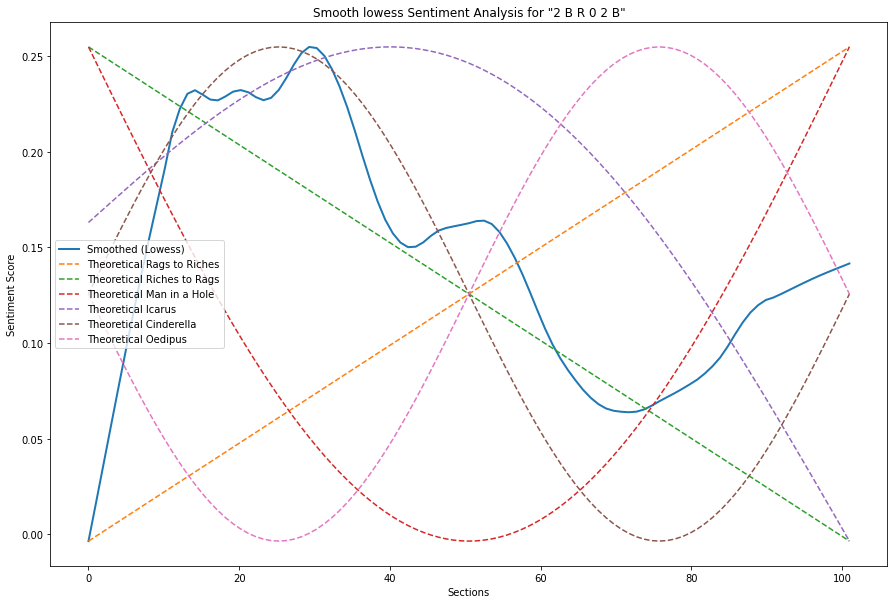

Final matching percentage for Rags to Riches: 14.60%
Final matching percentage for Riches to Rags: 39.09%
Final matching percentage for Man in a Hole: 12.99%
Final matching percentage for Icarus: 36.12%
Final matching percentage for Cinderella: 56.42%
Final matching percentage for Oedipus: 2.43%
The pattern with the highest matching percentage is 'Cinderella' with a percentage of 56.42%.


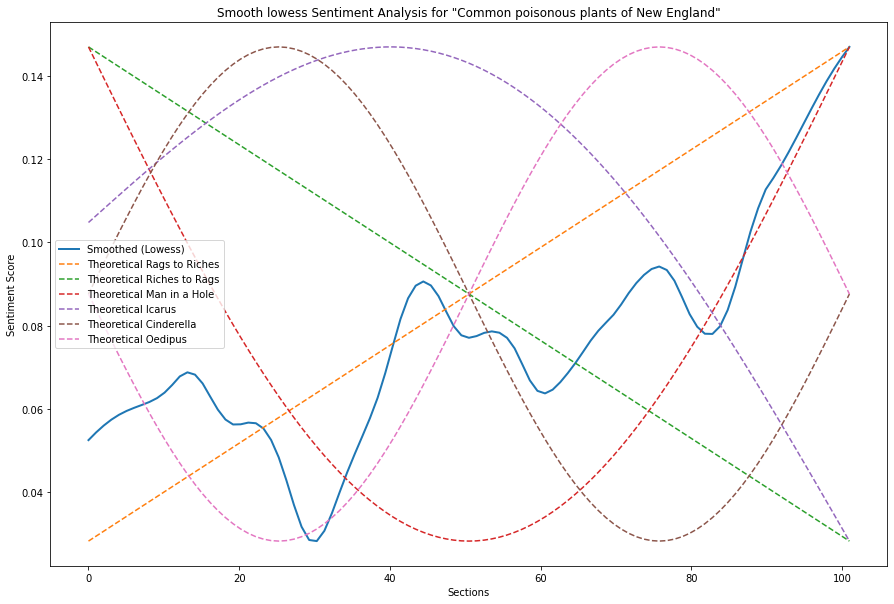

Final matching percentage for Rags to Riches: 50.67%
Final matching percentage for Riches to Rags: 9.23%
Final matching percentage for Man in a Hole: 30.29%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 6.68%
Final matching percentage for Oedipus: 34.91%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 50.67%.


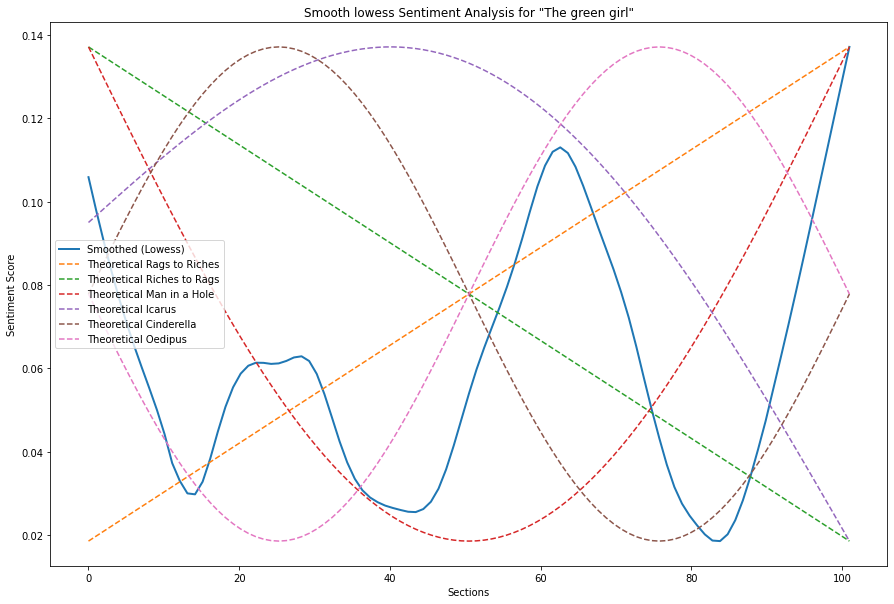

Final matching percentage for Rags to Riches: 31.65%
Final matching percentage for Riches to Rags: 21.21%
Final matching percentage for Man in a Hole: 35.07%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 12.02%
Final matching percentage for Oedipus: 26.32%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 35.07%.


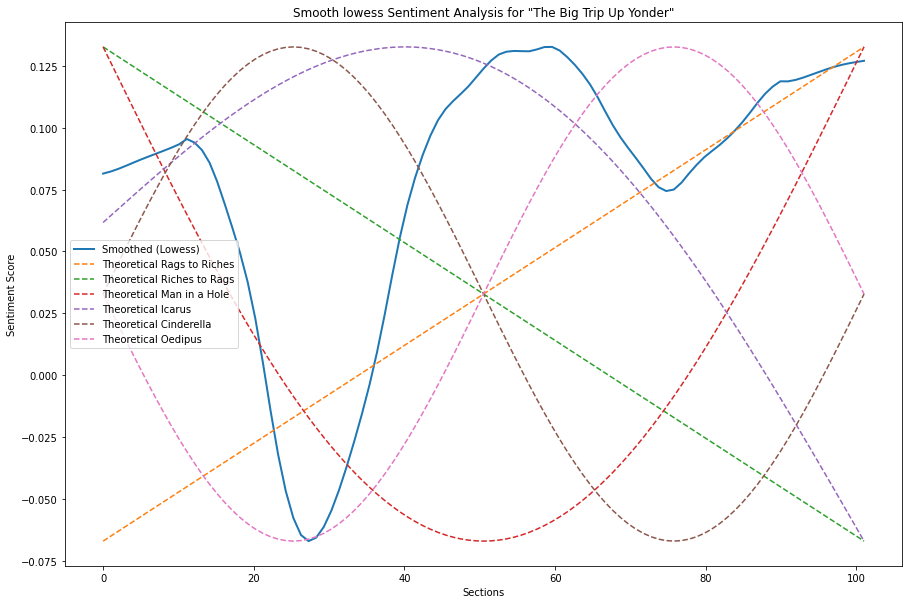

Final matching percentage for Rags to Riches: 41.10%
Final matching percentage for Riches to Rags: 12.81%
Final matching percentage for Man in a Hole: 14.95%
Final matching percentage for Icarus: 23.36%
Final matching percentage for Cinderella: 2.43%
Final matching percentage for Oedipus: 48.17%
The pattern with the highest matching percentage is 'Oedipus' with a percentage of 48.17%.


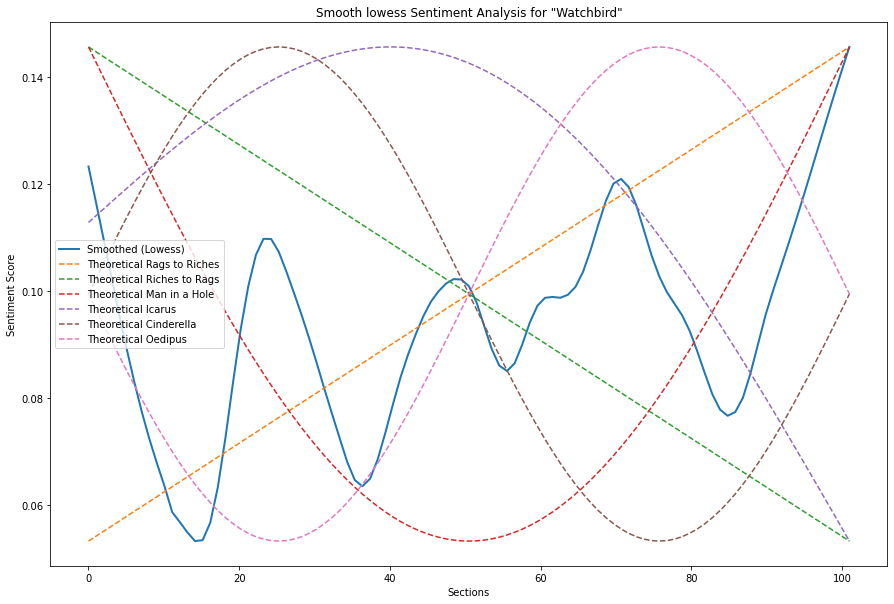

Final matching percentage for Rags to Riches: 34.08%
Final matching percentage for Riches to Rags: 10.54%
Final matching percentage for Man in a Hole: 22.99%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 4.63%
Final matching percentage for Oedipus: 25.45%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 34.08%.


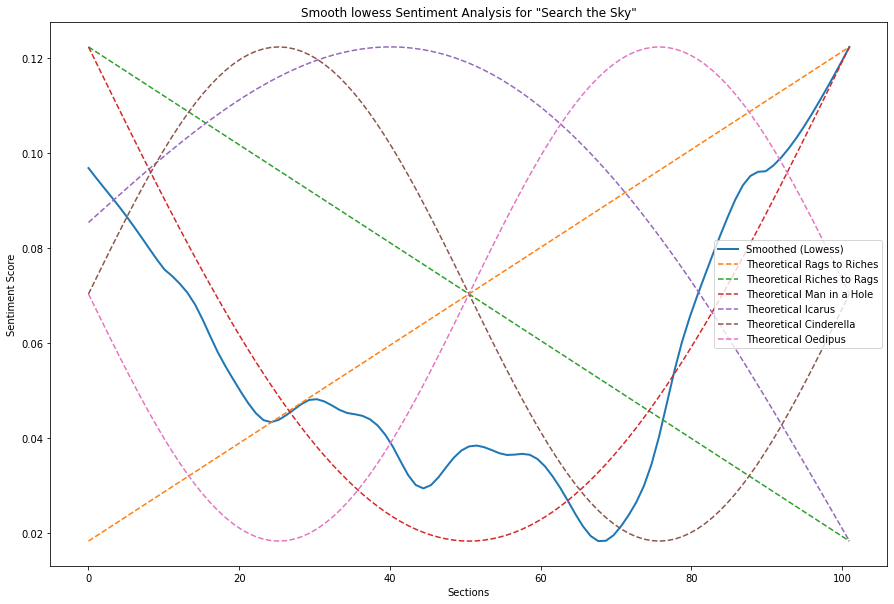

Final matching percentage for Rags to Riches: 21.89%
Final matching percentage for Riches to Rags: 15.13%
Final matching percentage for Man in a Hole: 55.71%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 13.80%
Final matching percentage for Oedipus: 14.81%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 55.71%.


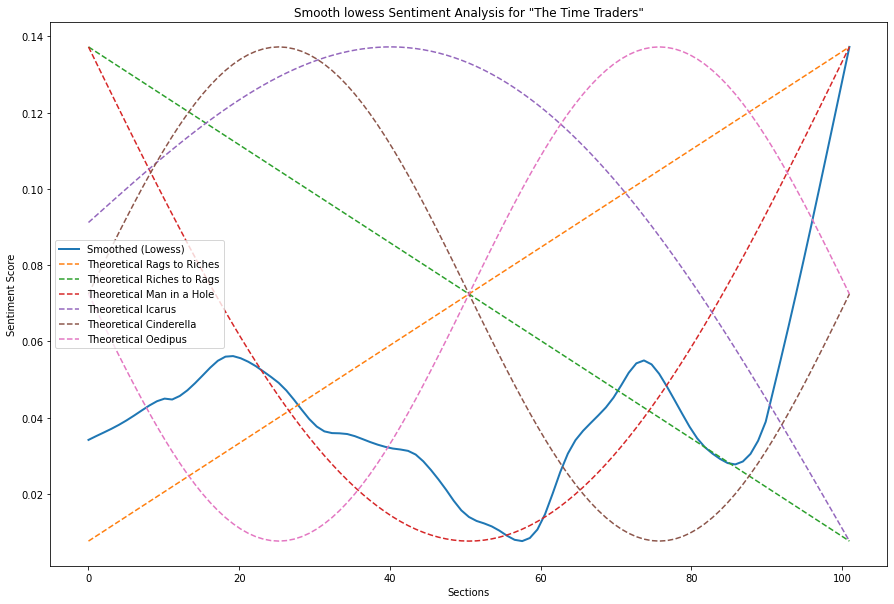

Final matching percentage for Rags to Riches: 27.86%
Final matching percentage for Riches to Rags: 20.10%
Final matching percentage for Man in a Hole: 46.47%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 19.89%
Final matching percentage for Oedipus: 18.06%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 46.47%.


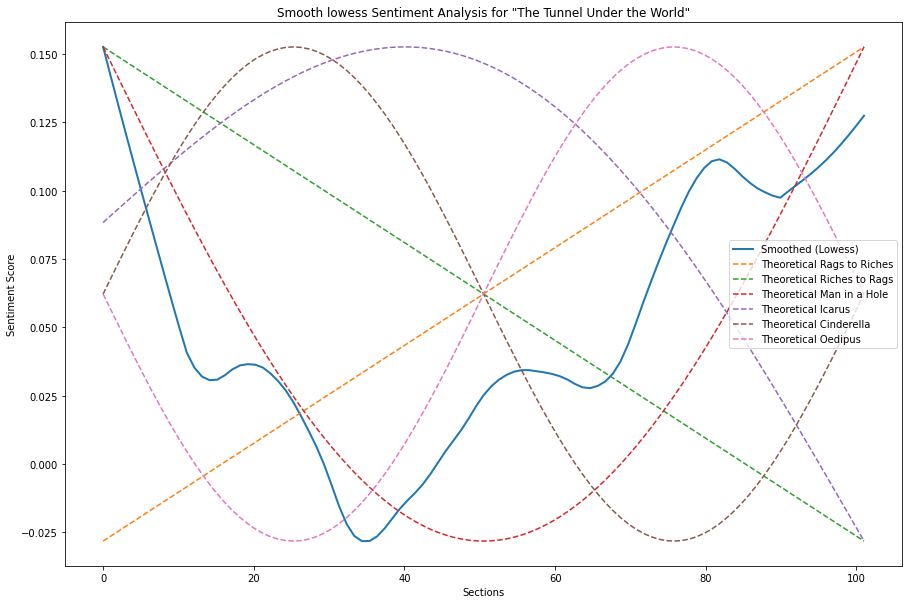

Final matching percentage for Rags to Riches: 34.20%
Final matching percentage for Riches to Rags: 14.69%
Final matching percentage for Man in a Hole: 53.08%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 6.09%
Final matching percentage for Oedipus: 37.39%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 53.08%.


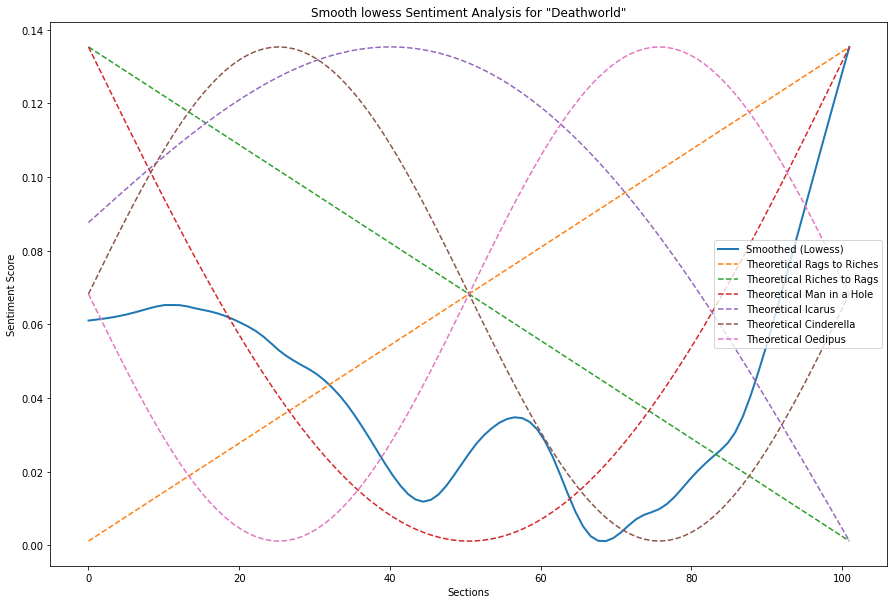

Final matching percentage for Rags to Riches: 19.67%
Final matching percentage for Riches to Rags: 21.67%
Final matching percentage for Man in a Hole: 53.87%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 25.36%
Final matching percentage for Oedipus: 10.20%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 53.87%.


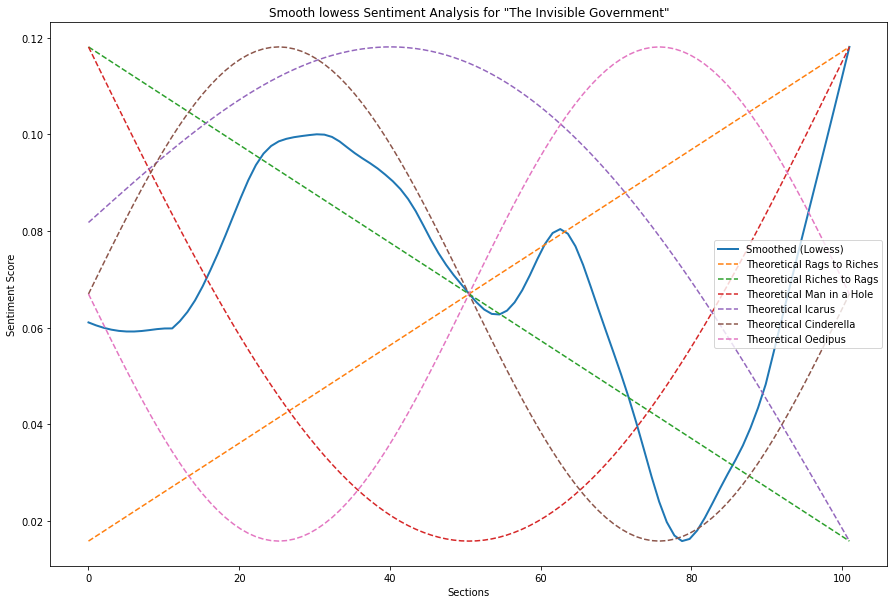

Final matching percentage for Rags to Riches: 15.59%
Final matching percentage for Riches to Rags: 28.87%
Final matching percentage for Man in a Hole: 13.93%
Final matching percentage for Icarus: 22.06%
Final matching percentage for Cinderella: 45.06%
Final matching percentage for Oedipus: 2.43%
The pattern with the highest matching percentage is 'Cinderella' with a percentage of 45.06%.


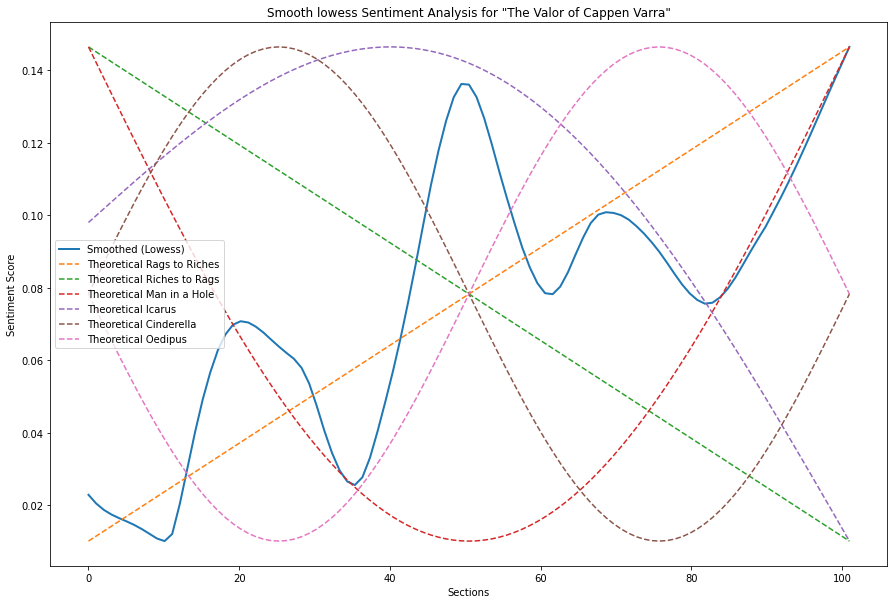

Final matching percentage for Rags to Riches: 50.70%
Final matching percentage for Riches to Rags: 2.76%
Final matching percentage for Man in a Hole: 9.53%
Final matching percentage for Icarus: 4.22%
Final matching percentage for Cinderella: 2.43%
Final matching percentage for Oedipus: 31.67%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 50.70%.


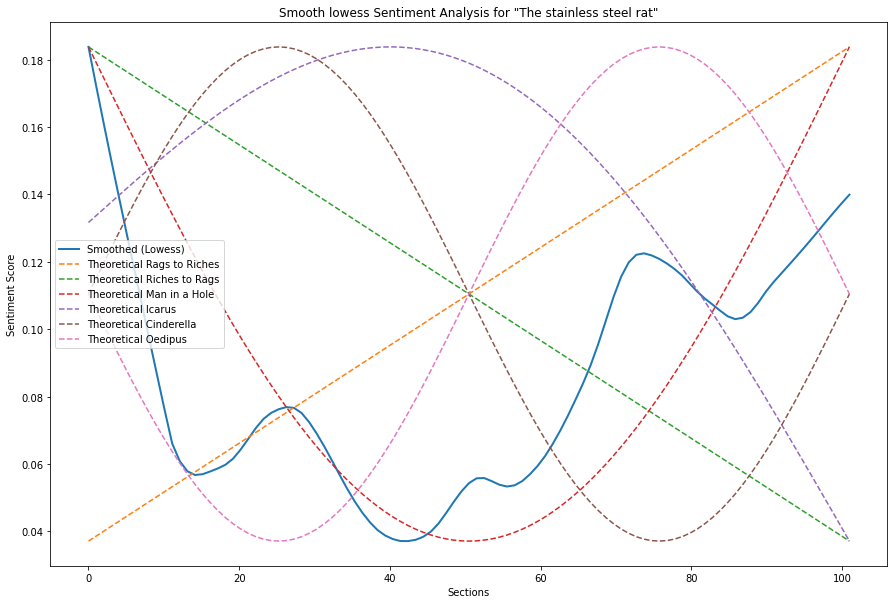

Final matching percentage for Rags to Riches: 27.84%
Final matching percentage for Riches to Rags: 17.31%
Final matching percentage for Man in a Hole: 51.82%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 9.57%
Final matching percentage for Oedipus: 31.58%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 51.82%.


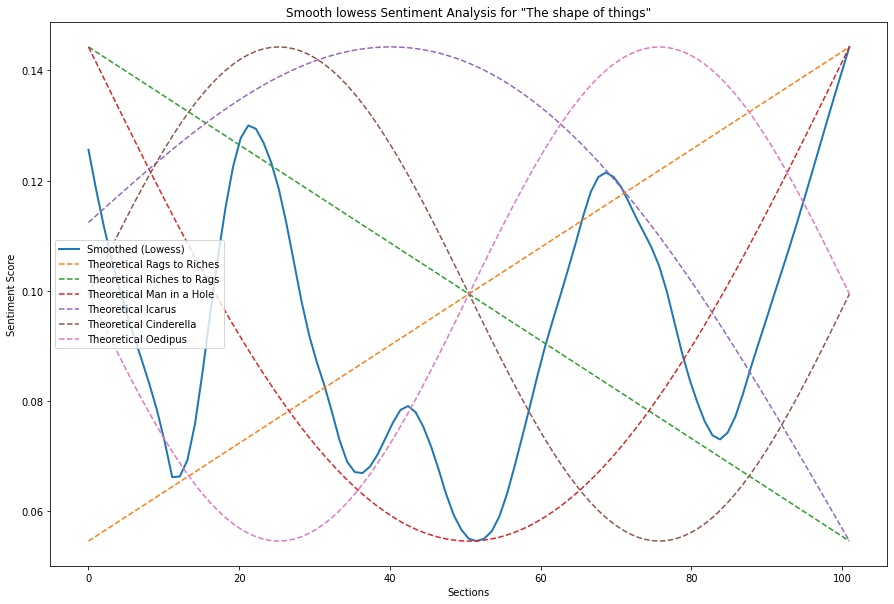

Final matching percentage for Rags to Riches: 25.66%
Final matching percentage for Riches to Rags: 17.32%
Final matching percentage for Man in a Hole: 33.84%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 12.40%
Final matching percentage for Oedipus: 17.71%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 33.84%.


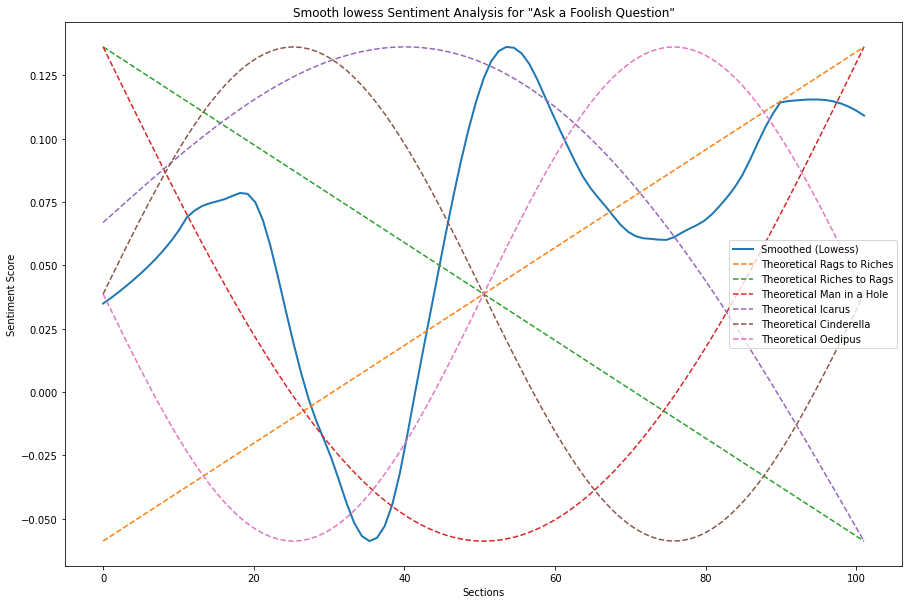

Final matching percentage for Rags to Riches: 40.67%
Final matching percentage for Riches to Rags: 11.33%
Final matching percentage for Man in a Hole: 18.52%
Final matching percentage for Icarus: 14.64%
Final matching percentage for Cinderella: 2.43%
Final matching percentage for Oedipus: 39.70%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 40.67%.


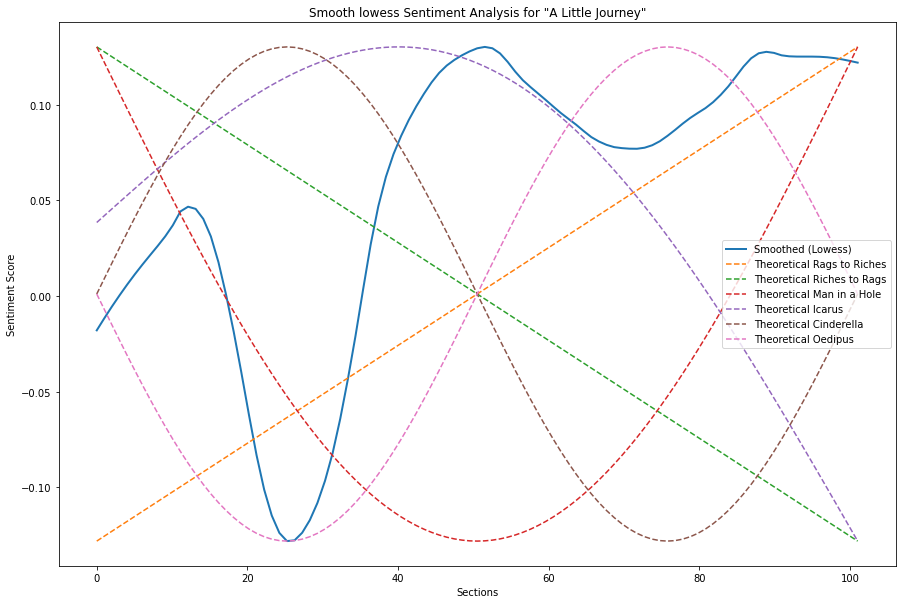

Final matching percentage for Rags to Riches: 51.79%
Final matching percentage for Riches to Rags: 8.47%
Final matching percentage for Man in a Hole: 11.42%
Final matching percentage for Icarus: 21.11%
Final matching percentage for Cinderella: 2.43%
Final matching percentage for Oedipus: 50.23%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 51.79%.


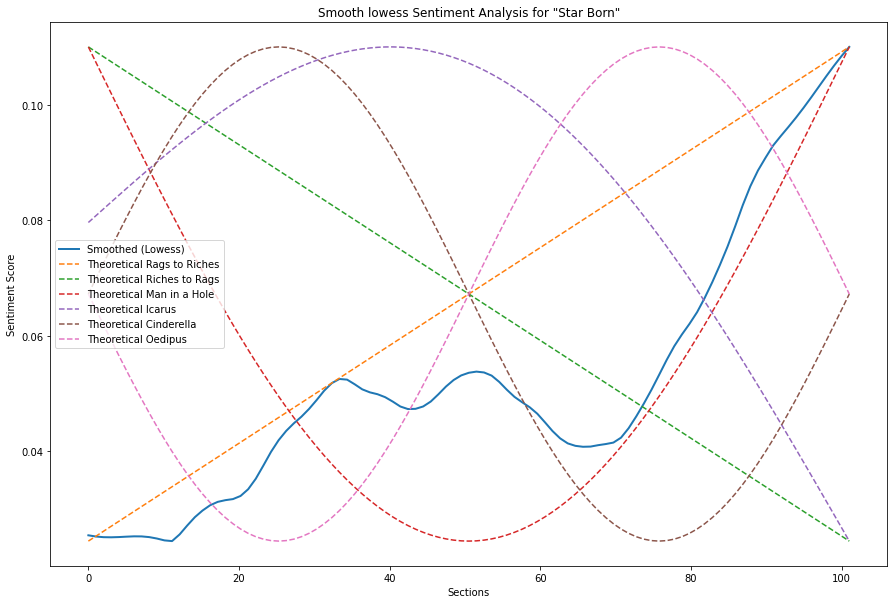

Final matching percentage for Rags to Riches: 50.73%
Final matching percentage for Riches to Rags: 8.79%
Final matching percentage for Man in a Hole: 28.58%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 10.09%
Final matching percentage for Oedipus: 28.77%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 50.73%.


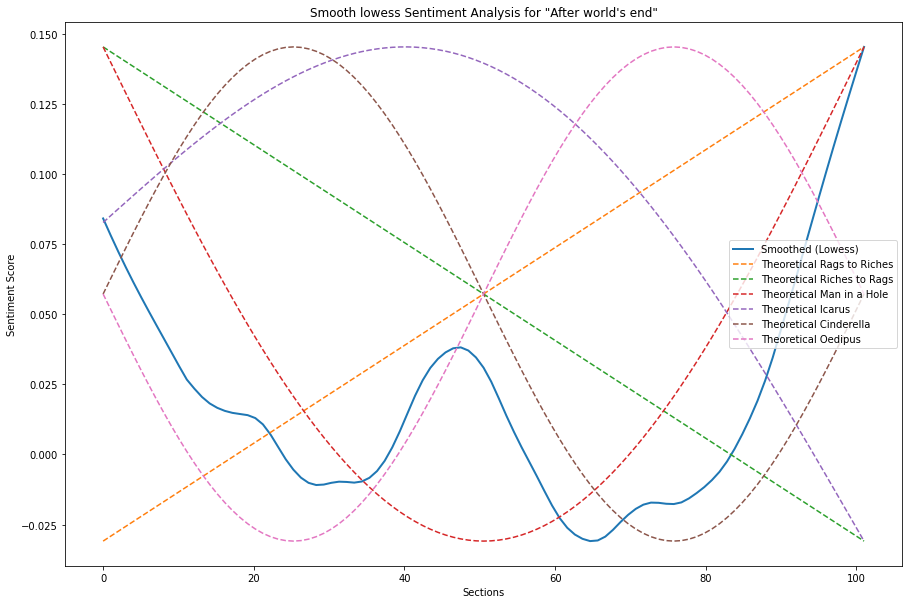

Final matching percentage for Rags to Riches: 24.27%
Final matching percentage for Riches to Rags: 20.87%
Final matching percentage for Man in a Hole: 53.02%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 20.15%
Final matching percentage for Oedipus: 15.96%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 53.02%.


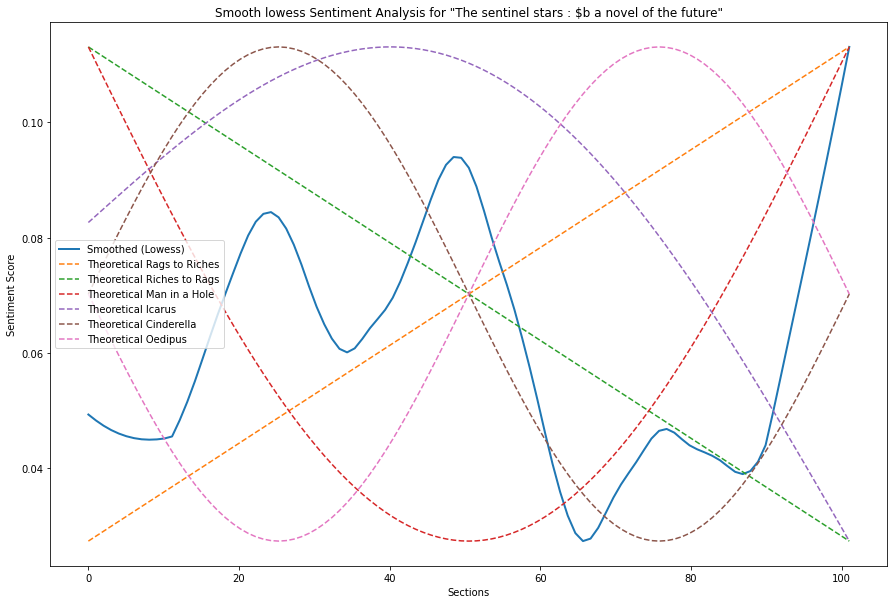

Final matching percentage for Rags to Riches: 20.35%
Final matching percentage for Riches to Rags: 22.76%
Final matching percentage for Man in a Hole: 19.31%
Final matching percentage for Icarus: 6.92%
Final matching percentage for Cinderella: 31.18%
Final matching percentage for Oedipus: 2.43%
The pattern with the highest matching percentage is 'Cinderella' with a percentage of 31.18%.


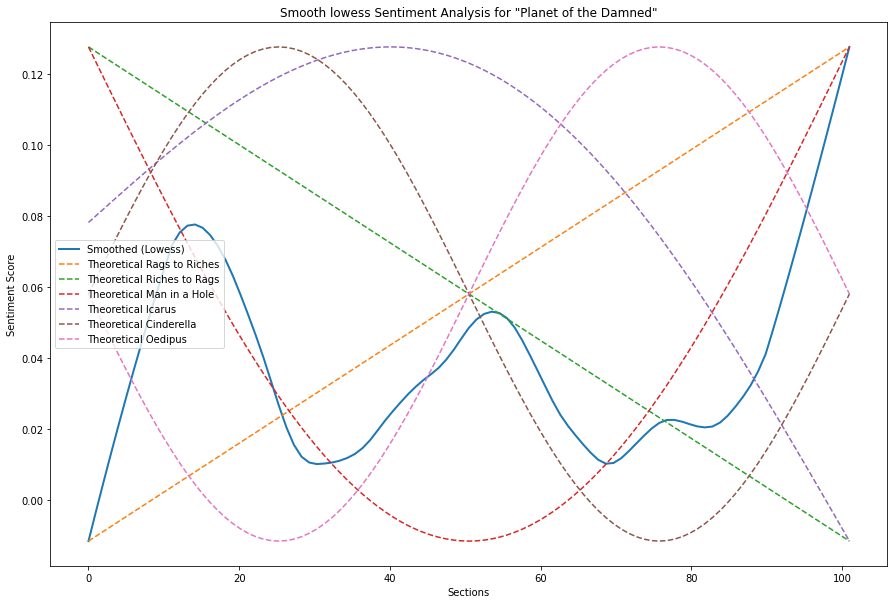

Final matching percentage for Rags to Riches: 29.59%
Final matching percentage for Riches to Rags: 21.70%
Final matching percentage for Man in a Hole: 38.54%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 22.11%
Final matching percentage for Oedipus: 15.05%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 38.54%.


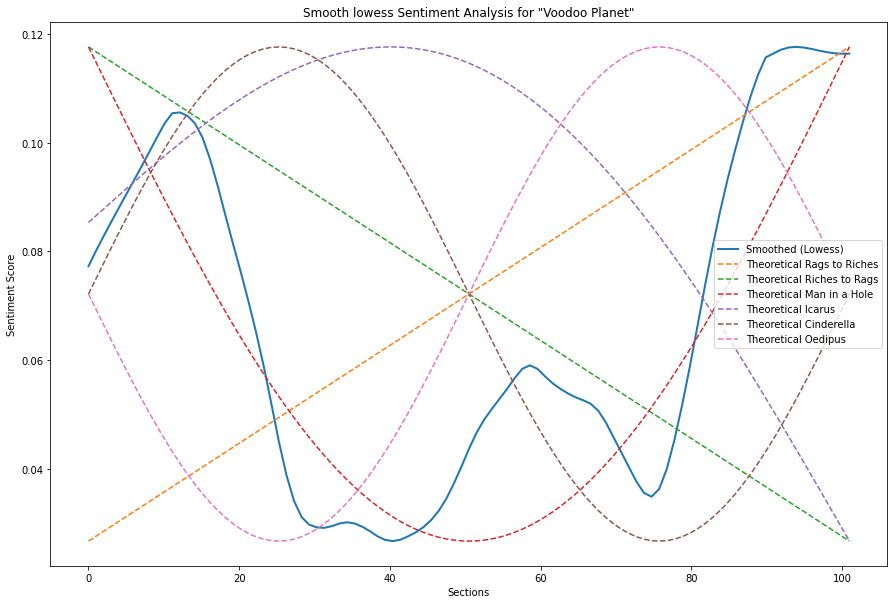

Final matching percentage for Rags to Riches: 20.92%
Final matching percentage for Riches to Rags: 14.20%
Final matching percentage for Man in a Hole: 52.84%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 11.49%
Final matching percentage for Oedipus: 16.59%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 52.84%.


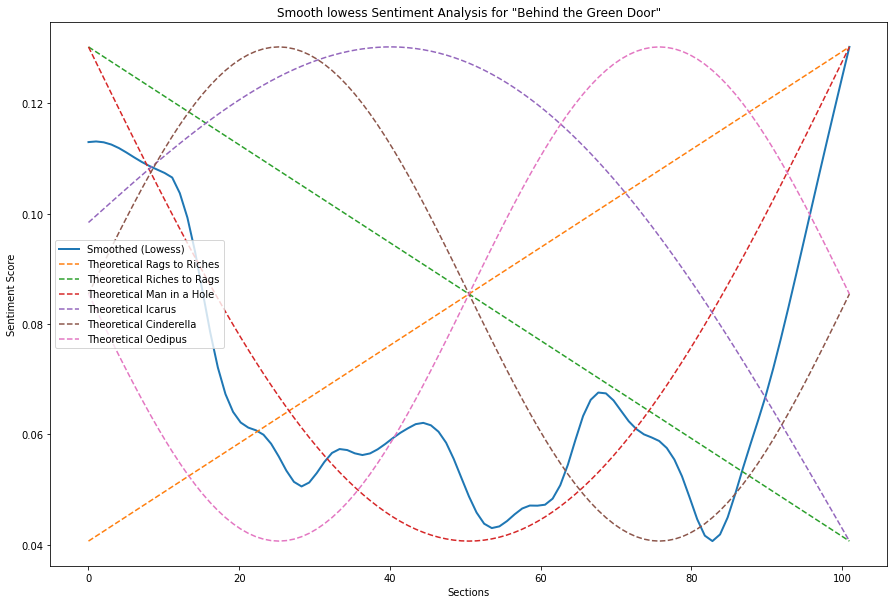

Final matching percentage for Rags to Riches: 13.85%
Final matching percentage for Riches to Rags: 21.14%
Final matching percentage for Man in a Hole: 54.40%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 16.84%
Final matching percentage for Oedipus: 10.31%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 54.40%.


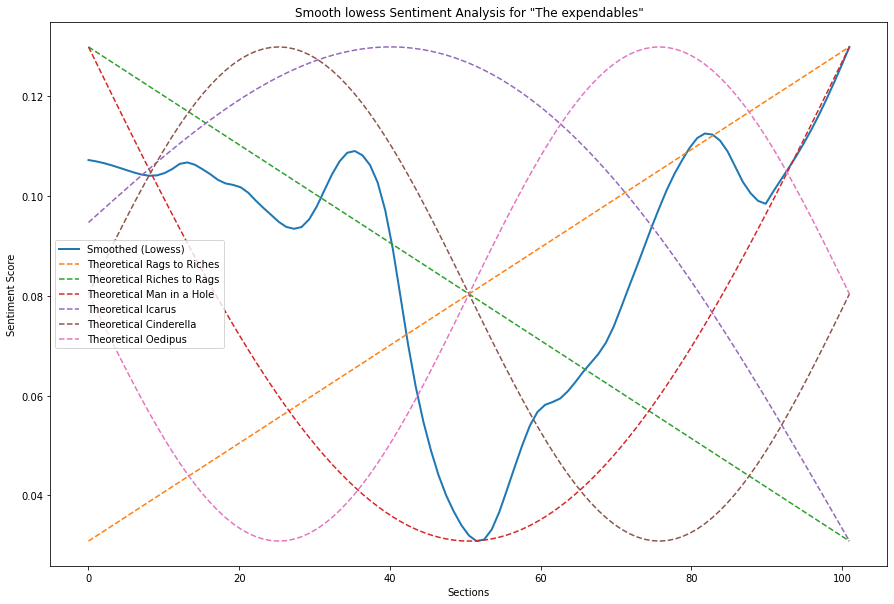

Final matching percentage for Rags to Riches: 15.46%
Final matching percentage for Riches to Rags: 16.47%
Final matching percentage for Man in a Hole: 43.03%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 14.44%
Final matching percentage for Oedipus: 2.44%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 43.03%.


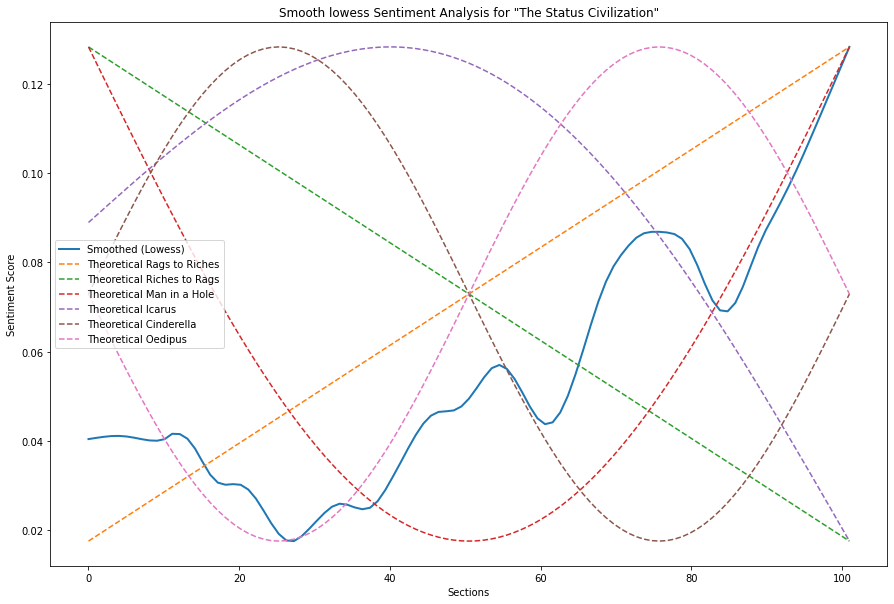

Final matching percentage for Rags to Riches: 52.55%
Final matching percentage for Riches to Rags: 9.90%
Final matching percentage for Man in a Hole: 35.20%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 6.12%
Final matching percentage for Oedipus: 44.49%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 52.55%.


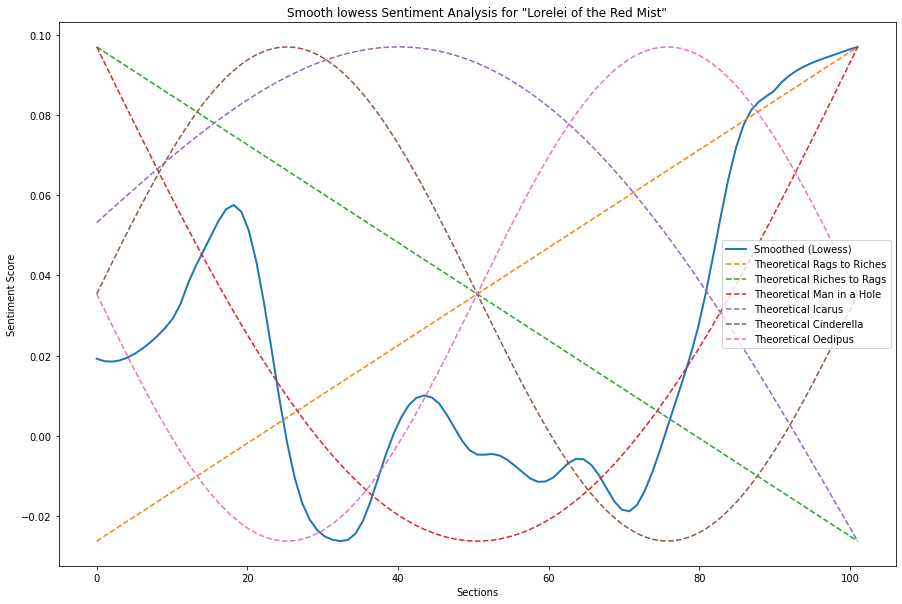

Final matching percentage for Rags to Riches: 31.11%
Final matching percentage for Riches to Rags: 14.12%
Final matching percentage for Man in a Hole: 50.72%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 14.21%
Final matching percentage for Oedipus: 19.95%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 50.72%.


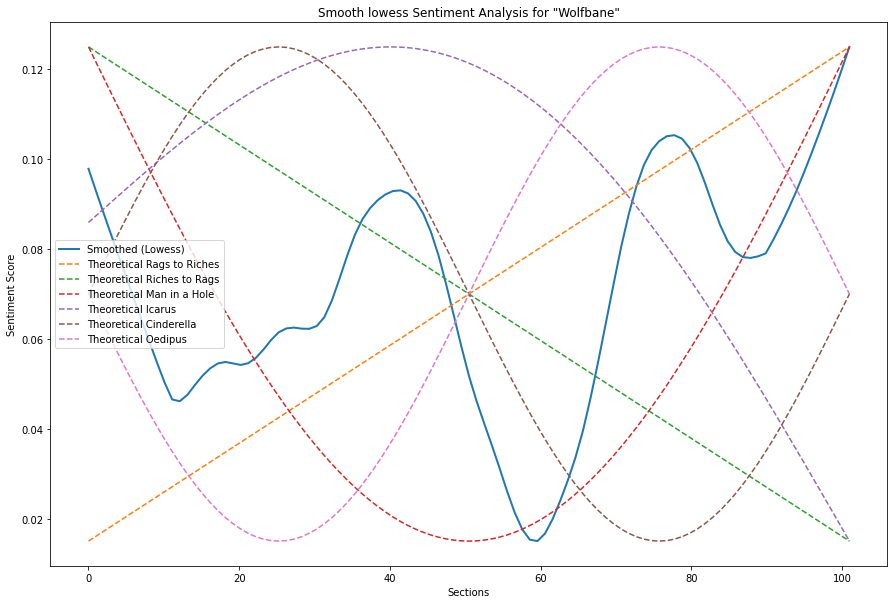

Final matching percentage for Rags to Riches: 34.00%
Final matching percentage for Riches to Rags: 12.37%
Final matching percentage for Man in a Hole: 29.71%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 9.51%
Final matching percentage for Oedipus: 19.21%
The pattern with the highest matching percentage is 'Rags to Riches' with a percentage of 34.00%.


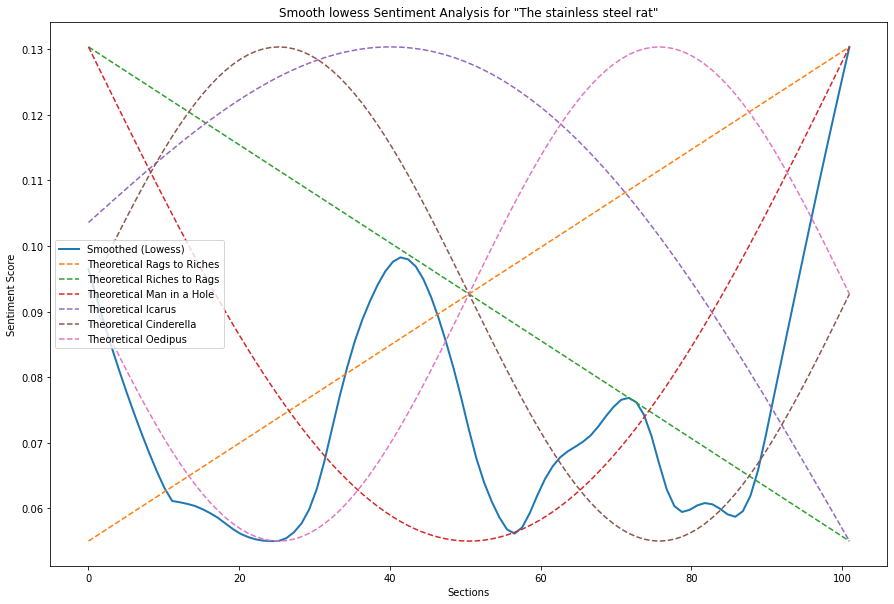

Final matching percentage for Rags to Riches: 27.46%
Final matching percentage for Riches to Rags: 18.62%
Final matching percentage for Man in a Hole: 33.79%
Final matching percentage for Icarus: 2.43%
Final matching percentage for Cinderella: 17.99%
Final matching percentage for Oedipus: 18.20%
The pattern with the highest matching percentage is 'Man in a Hole' with a percentage of 33.79%.


In [4]:
pattern_count_dict = {}

# Create sentiment analysis charts with smoothed curve lines for each book
for i, book_id in enumerate(book_ids):
    book = {}  # Create a dictionary to store book information
    highest_percentage = 0
    highest_pattern = None
    # Fetch book text using the Gutendex API
    text_url, book_data = fetch_book_text(book_id)
    if text_url is None:
        continue

    try:
        response = http.get(text_url)
        response.raise_for_status()
        text = response.text
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch text for book {book_id}: {e}")
        continue

    preprocessed_text = text  # Replace with actual preprocessing
    num_sections = 100  # Number of sections for sentiment analysis
    section_size = len(preprocessed_text) // num_sections
    sections = [preprocessed_text[i:i + section_size] for i in range(0, len(preprocessed_text), section_size)]


  
    # Sentiment analysis
    y = [TextBlob(section).sentiment.polarity for section in sections]
    x = np.linspace(0, len(sections), len(sections))
    y_smooth = lowess(y, x, frac=0.24)[:, 1]


   
    # Get min and max of smoothed curve to scale theoretical patterns
    y_min = np.min(y_smooth)
    y_max = np.max(y_smooth)

    # RMSE and Correlation calculations
    rmse_values = {}
    correlation_values = {}
    book_title = "Unknown Title"
    if book_data and 'title' in book_data:
        book_title = book_data['title']
    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(x, y_smooth, label='Smoothed (Lowess)', linewidth=2)
    
    theoretical_patterns = ['Rags to Riches', 'Riches to Rags', 'Man in a Hole', 'Icarus', 'Cinderella', 'Oedipus']
    normalized_rmse = {pattern: (rmse - min_rmse) / (max_rmse - min_rmse) for pattern, rmse in rmse_values.items()}
    normalized_corr = {pattern: (max_corr - corr) / (max_corr - min_corr) for pattern, corr in correlation_values.items()}
    
    for pattern in theoretical_patterns:
        theoretical_curve = generate_theoretical_pattern(pattern, len(x))
        scaled_theoretical_curve = scale_theoretical_pattern(theoretical_curve, y_min, y_max)
       
        rmse = calculate_rmse(y_smooth, scaled_theoretical_curve)
        corr = calculate_pearson_correlation(y_smooth, scaled_theoretical_curve)
        
        rmse_values[pattern] = rmse
        correlation_values[pattern] = corr

        plt.plot(x, scaled_theoretical_curve, label=f'Theoretical {pattern}', linestyle='--')
    
    plt.xlabel('Sections')
    plt.ylabel('Sentiment Score')
    plt.title(f'Smooth lowess Sentiment Analysis for "{book_title}"')
    plt.legend()
    plt.show()

    # Calculate matching percentages
    min_rmse = min(rmse_values.values())
    max_rmse = max(rmse_values.values())

    min_corr = min(correlation_values.values())
    max_corr = max(correlation_values.values())

    for pattern in theoretical_patterns:
        rmse_percentage = calculate_penalty_percentage(min_rmse, max_rmse, rmse_values[pattern], rmse_penalty_factor, lower_cap=2.38, upper_cap=80)
        corr_percentage = calculate_penalty_percentage(min_corr, max_corr, 1 - correlation_values[pattern], corr_penalty_factor, lower_cap=2.5, upper_cap=80)
        rmse_weight = 0.6
        corr_weight = 0.4
 
        
        final_percentage = (rmse_weight * rmse_percentage) + (corr_weight * corr_percentage)
        if final_percentage > highest_percentage:
            
            highest_percentage = final_percentage
            highest_pattern = pattern
            pattern_count_dict[highest_pattern] = pattern_count_dict.get(highest_pattern, 0) + 1
            
        print(f"Final matching percentage for {pattern}: {final_percentage:.2f}%")
    print(f"The pattern with the highest matching percentage is '{highest_pattern}' with a percentage of {highest_percentage:.2f}%.")


In [5]:
print("Kurt Vonnegut Pattern Count Dictionary 2000s:")
for pattern, count in pattern_count_dict.items():
    print(f"{pattern}: {count}")

Kurt Vonnegut Pattern Count Dictionary 2000s:
Rags to Riches: 26
Riches to Rags: 6
Cinderella: 3
Man in a Hole: 14
Oedipus: 1


In [6]:
patterns = list(pattern_count_dict.keys())
counts = list(pattern_count_dict.values())

fig = go.Figure(data=[
    go.Bar(name='Pattern Count', x=patterns, y=counts)
])

# Customize layout
fig.update_layout(
    title='Kurt Vonnegut Story Shapes Distribution 2000s',
    xaxis=dict(title='Patterns'),
    yaxis=dict(title='Count'),
    barmode='group'
)
fig.show()